In [2]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
import pickle
from shutil import copyfile
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.filters import threshold_otsu as otsu
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [4]:
def binarize_image(data,scale,binarize):
    if binarize:
        threshold = otsu(data)*scale
        data_binarized = np.where(data>threshold, 1, 0)
        return data_binarized
    else:
        return data
    
def calc_centroid(binary_image):
    return scipy.ndimage.measurements.center_of_mass(binary_image)

def calc_centroid_alex(binary_image):
    return np.argwhere(binary_image==1).mean(0)
        
def plot_centroid(cx,cy,cz,axis,color='r'):
    if axis==0:
        plt.scatter(cz,cy,color=color)
    elif axis==1:
        plt.scatter(cz,cx,color=color)
    elif axis==2:
        plt.scatter(cy,cx,color=color)
    
def draw_grid(vlines=5, hlines=5, lw=.5):
    for i in np.arange(0,vlines*20,20):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*20,20):
        plt.axhline(i,color='w',lw=lw)
        
def clean_anat(brain):
    brain_copy = brain.copy().astype('float32')
    brain_copy = scipy.ndimage.filters.gaussian_filter(brain_copy, sigma=0.5)

    labels, label_nb = scipy.ndimage.label(brain_copy)
    brain_label = np.bincount(labels.flatten())[1:].argmax()+1

    brain_copy = np.where(labels==brain_label, 1.0, 0.0)

    return brain_copy*brain

In [5]:
bbox = {'x_start': 200, 'x_end': 325,
        'y_start': 150, 'y_end': 225,
        'z_start': 40, 'z_end': 140}

In [24]:
###########################################
### Load warped indiv LC11 gloms in FDA ###
###########################################

brains = {}
brains_cropped = {}
brain_types = ['clandinin', 'murthy', 'clandinin_flip', 'murthy_flip', 'connectome']
for brain_type in brain_types:
    if 'clandinin' in brain_type:
        #dir_ = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221029_FDA_direct_affine/clandinin"
        dir_ = "/oak/stanford/groups/trc/data/Alex/clab_data/LC11/func/synthmorph_to_FDA"
    elif 'murthy' in brain_type:
        #dir_ = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221029_FDA_direct_affine/murthy"
        dir_ = "/oak/stanford/groups/trc/data/Alex/albert_data/LC11/func/synthmorph_to_FDA"
    elif 'connectome' in brain_type:
        LC11_fda_path = "/oak/stanford/groups/trc/data/Alex/clab_data/LC11/LC11_FDA_ds_flip.nii"
        LC11_fda = ants.image_read(LC11_fda_path)[:]
        LC11_fda_cropped = LC11_fda[bbox['x_start']:bbox['x_end'],
                           bbox['y_start']:bbox['y_end'],
                           bbox['z_start']:bbox['z_end']]
        brains[brain_type] = [LC11_fda]
        brains_cropped[brain_type] = [LC11_fda_cropped]
        continue
        
    brains[brain_type] = []
    files = [x for x in os.listdir(dir_)]
    for file in files:
        print(file)
        to_load = os.path.join(dir_,file)
        image = ants.image_read(to_load)
        
        if 'flip' in brain_type:
            image = image[::-1,:,:]
        
        brains[brain_type].append(image)

210223_04_fda.nii
210216_02_fda.nii
210223_01_fda.nii
210208_02_fda.nii
210223_02_fda.nii
210208_03_fda.nii
210216_04_fda.nii
210218_02_fda.nii
210223_03_fda.nii
220426_LC11_vol1_fda.nii
220426_LC11_vol2_fda.nii
220420_LC11_vol1_fda.nii
220412_LC11_vol1_fda.nii
220425_LC11_vol1_fda.nii
220420_LC11_vol2_fda.nii
220413_LC11_vol1_fda.nii
220419_LC11_vol2_fda.nii
210223_04_fda.nii
210216_02_fda.nii
210223_01_fda.nii
210208_02_fda.nii
210223_02_fda.nii
210208_03_fda.nii
210216_04_fda.nii
210218_02_fda.nii
210223_03_fda.nii
220426_LC11_vol1_fda.nii
220426_LC11_vol2_fda.nii
220420_LC11_vol1_fda.nii
220412_LC11_vol1_fda.nii
220425_LC11_vol1_fda.nii
220420_LC11_vol2_fda.nii
220413_LC11_vol1_fda.nii
220419_LC11_vol2_fda.nii


In [7]:
file = "/oak/stanford/groups/trc/data/Yukun/registration/mean_brain/FDA_downsampled_flip.nii"
FDA = ants.image_read(file)

In [34]:
for brain_type in brain_types:
    brains_cropped[brain_type] = []
    for i in range(len(brains[brain_type])):
        ### crop to bounding box
        brains_cropped[brain_type].append(brains[brain_type][i][bbox['x_start']:bbox['x_end'],
                   bbox['y_start']:bbox['y_end'],
                   bbox['z_start']:bbox['z_end']])

In [9]:
brains['clandinin'][0].shape

(826, 384, 240)

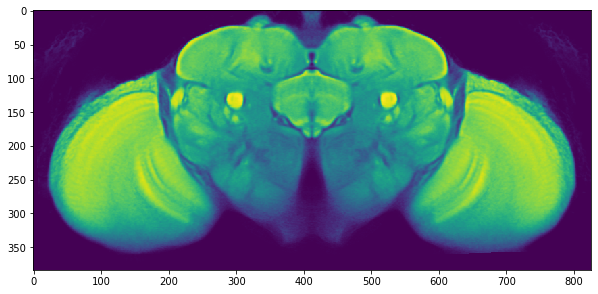

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(FDA[:,:,100].T)

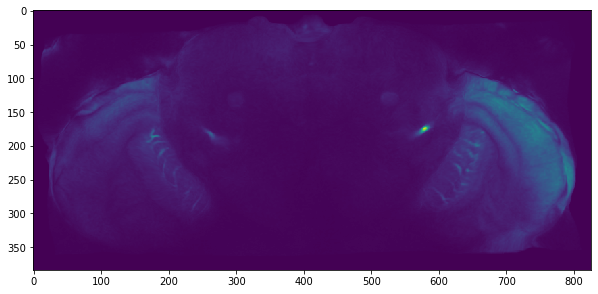

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(brains['clandinin'][6][:,:,100].T)

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(brains_cropped['clandinin'][5],axis=2).T)

KeyError: 'clandinin'

<Figure size 720x720 with 0 Axes>

In [138]:
brains['clandinin'][0]

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (826, 384, 240)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [28]:
########################################################
### Generate normalized mean images of green channel ### #NOT CROPPED
########################################################

meanbrains = {}
for brain_type in brain_types:
    meanbrain = np.zeros(brains[brain_type][0].shape)
    for i in range(len(brains[brain_type])): 
        try:
            meanbrain += brains[brain_type][i]
        except:
            meanbrain += brains[brain_type][i].numpy()
    meanbrains[brain_type] = meanbrain

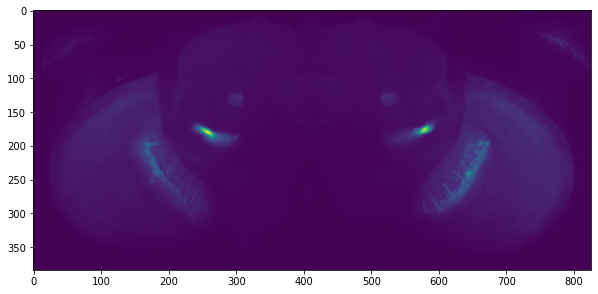

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(meanbrains['clandinin'][:,:,100].T)

In [158]:
file = "/oak/stanford/groups/trc/data/Yukun/registration/mean_brain/LC11_to_FDA/brig3.nii"
#file = "/oak/stanford/groups/trc/data/Alex/albert_data/LC11/anat/LC11_to_FDA/brig3.nii"
out = ants.image_read(file)

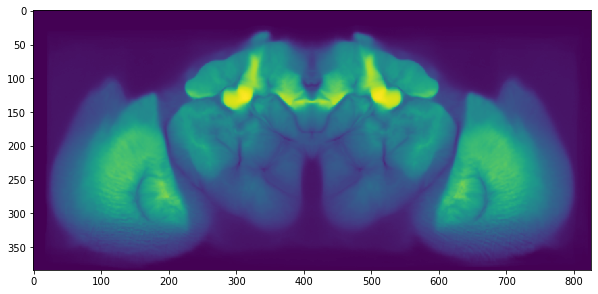

In [159]:
plt.figure(figsize=(10,10))
plt.imshow(out[:,:,140].T)

In [46]:
########################################################
### Generate normalized mean images of green channel ###
########################################################

meanbrains = {}
for brain_type in brain_types:
    meanbrain = np.zeros(brains_cropped[brain_type][0].shape)
    for i in range(len(brains_cropped[brain_type])):
        max_value = np.max(brains_cropped[brain_type][i])
        if max_value == 0:
            max_value = 1            
        meanbrain += brains_cropped[brain_type][i]/max_value
    meanbrains[brain_type] = meanbrain

In [35]:
###########################
### calculate centroids ###
###########################

thresh_scales = {'clandinin': [1,1,1,1,1,1,1,1,1],
                 'murthy': [2,2,2,1.5,1,1.5,1.5,1.5],
                 'clandinin_flip': [1,1,1,1,1,1,2,1,1],
                 'murthy_flip': [1,2,2,1,1,2,1,2],
                 'connectome':[1]}

centroids = {}
for brain_type in brain_types:
    centroids[brain_type] = []
    for i in range(len(brains_cropped[brain_type])):
        try:
            binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize=True)
        except:
            continue
        #binary_image = binarize_image(brains_cropped[brain_type][i],1,binarize=True)

        binary_image*=pvlp_mask_cropped
        binary_image = clean_anat(binary_image)
        cx,cy,cz = calc_centroid(binary_image)
        centroids[brain_type].append((cx,cy,cz))

In [37]:
LC11_fda_cropped.shape

(125, 75, 100)

In [41]:
brains_cropped['clandinin'][0].shape

(125, 75, 100)

In [36]:
plt.figure(figsize=(10,10))
axis = 1
uncropped = True

type1 = 'clandinin'
type2 = 'murthy'

if uncropped:
    g=np.max(meanbrains[type1],axis=axis)
    r=np.max(meanbrains[type2],axis=axis)
    b=np.max(LC11_fda_cropped*pvlp_mask_cropped, axis=axis)
else:
    g=np.max(mean_binary_image_c,axis=axis)
    r=np.max(mean_binary_image_m,axis=axis)
    b=np.max(LC11_fda_cropped*pvlp_mask_cropped, axis=axis)

#b = np.zeros(g.shape)
    
g/=np.max(g)
r/=np.max(r)
b/=np.max(b)
rgb = np.concatenate((r[...,np.newaxis],g[...,np.newaxis],b[...,np.newaxis]),axis=2)
plt.imshow(rgb)

for i in range(len(centroids[type1])):
    plot_centroid(centroids[type1][i][0],
                  centroids[type1][i][1],
                  centroids[type1][i][2],axis,color='w')
    
for i in range(len(centroids[type2])):
    plot_centroid(centroids[type2][i][0],
                  centroids[type2][i][1],
                  centroids[type2][i][2],axis,color='blue')
    
for i in range(len(centroids['connectome'])):
    plot_centroid(centroids['connectome'][i][0],
                  centroids['connectome'][i][1],
                  centroids['connectome'][i][2],axis,color='r')

draw_grid(vlines=5, hlines=6, lw=2)
plt.axis('off')

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 826 and the array at index 2 has size 125

<Figure size 720x720 with 0 Axes>

In [15]:
##################
### load masks ###
##################

pvlp_mask = "/oak/stanford/groups/trc/data/Alex/ROI_masks/pvlp_and_plp.nii"
pvlp_mask = ants.image_read(pvlp_mask).numpy()
mask_eroded = binary_erosion(pvlp_mask, structure=np.ones((2,2,2)))
mask_dilated = binary_dilation(mask_eroded, iterations=2)
pvlp_mask_cropped = mask_dilated[bbox['x_start']:bbox['x_end'],
                               bbox['y_start']:bbox['y_end'],
                               bbox['z_start']:bbox['z_end']]

# nolo_mask = "/oak/stanford/groups/trc/data/Alex/ROI_masks/no_lo.nii"
# nolo_mask = ants.image_read(nolo_mask).numpy()
# mask_eroded = binary_erosion(nolo_mask, structure=np.ones((2,2,2)))
# mask_dilated = binary_dilation(mask_eroded, iterations=2)
# nolo_mask_cropped = mask_dilated[bbox['x_start']:bbox['x_end'],
#                                bbox['y_start']:bbox['y_end'],
#                                bbox['z_start']:bbox['z_end']]

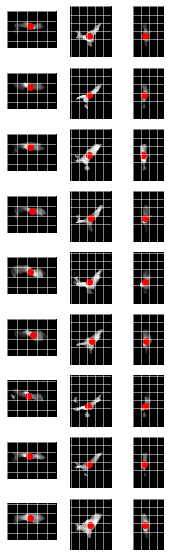

In [42]:
plt.figure(figsize=(3,10))
binarize=True
brain_type = 'clandinin'
for i in range(len(brains_cropped[brain_type])):
    for axis in [0,1,2]:
        plt.subplot(9,3,(3*i+axis)+1)
        binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize)
        binary_image*=pvlp_mask_cropped
        binary_image = clean_anat(binary_image)
        plt.imshow(np.mean(binary_image,axis=axis),cmap='Greys_r')
        draw_grid()
        plt.axis('off')
        cx,cy,cz = calc_centroid(binary_image)
        plot_centroid(cx,cy,cz,axis)

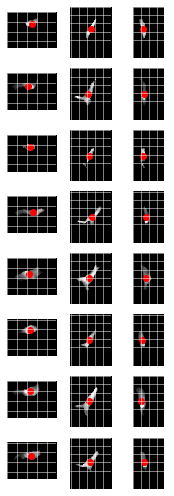

In [43]:
plt.figure(figsize=(3,10))
binarize=True
brain_type = 'murthy'
for i in range(len(brains_cropped[brain_type])):
    for axis in [0,1,2]:
        plt.subplot(9,3,(3*i+axis)+1)
        binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize)
        binary_image*=pvlp_mask_cropped
        binary_image = clean_anat(binary_image)
        plt.imshow(np.mean(binary_image,axis=axis),cmap='Greys_r')
        draw_grid()
        plt.axis('off')
        cx,cy,cz = calc_centroid(binary_image)
        plot_centroid(cx,cy,cz,axis)

(125, 100)
(125, 100)
(125, 100)
(125, 100)
(125, 100)
(125, 100)
(125, 100)
(125, 100)
(125, 100)


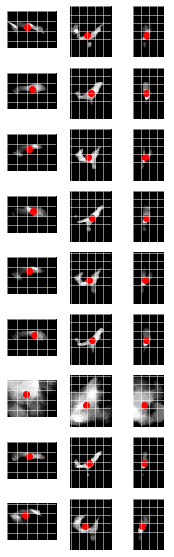

In [49]:
plt.figure(figsize=(3,10))
binarize=True
brain_type = 'clandinin'
for i in range(len(brains_cropped[brain_type])):
    for axis in [0,1,2]:
        plt.subplot(9,3,(3*i+axis)+1)
        binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize)
        binary_image*=pvlp_mask_cropped
        binary_image = clean_anat(binary_image)
        plt.imshow(np.mean(binary_image,axis=axis),cmap='Greys_r')
        draw_grid()
        plt.axis('off')
        #cx,cy,cz = calc_centroid(binary_image)
        plot_centroid(centroids[type1][i][0],
                      centroids[type1][i][1],
                      centroids[type1][i][2],axis)
        if axis==1:
            print(np.mean(binary_image,axis=axis).shape)

In [ ]:
brains_cropped['clandinin']

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


(-0.5, 84.025, 124.5, -0.5)

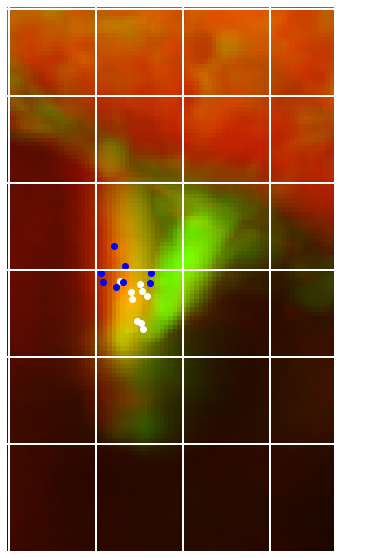

In [52]:
plt.figure(figsize=(10,10))
axis = 2
uncropped = True


type1 = 'clandinin'
type2 = 'murthy'

if uncropped:
    g=np.max(meanbrains[type1],axis=axis)
    r=np.max(meanbrains[type2],axis=axis)
    #b=np.max(LC11_fda_cropped*pvlp_mask_cropped, axis=axis)
else:
    g=np.max(mean_binary_image_c,axis=axis)
    r=np.max(mean_binary_image_m,axis=axis)
    #b=np.max(LC11_fda_cropped*pvlp_mask_cropped, axis=axis)

b = np.zeros(g.shape)
    
g/=np.max(g)
r/=np.max(r)
b/=np.max(b)
rgb = np.concatenate((r[...,np.newaxis],g[...,np.newaxis],b[...,np.newaxis]),axis=2)
plt.imshow(rgb)

for i in range(len(centroids[type1])):
    plot_centroid(centroids[type1][i][0],
                  centroids[type1][i][1],
                  centroids[type1][i][2],axis,color='w')
    
for i in range(len(centroids[type2])):
    plot_centroid(centroids[type2][i][0],
                  centroids[type2][i][1],
                  centroids[type2][i][2],axis,color='blue')
    
# for i in range(len(centroids['connectome'])):
#     plot_centroid(centroids['connectome'][i][0],
#                   centroids['connectome'][i][1],
#                   centroids['connectome'][i][2],axis,color='r')

draw_grid(vlines=5, hlines=6, lw=2)
plt.axis('off')

In [48]:
rgb.shape

(125, 100, 3)

In [ ]:
def plot_centroid(cx,cy,cz,axis,color='r'):
    if axis==0:
        plt.scatter(cz,cy,color=color)
    elif axis==1:
        plt.scatter(cz,cx,color=color)
    elif axis==2:
        plt.scatter(cy,cx,color=color)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


(-0.5, 99.5, 124.5, -0.5)

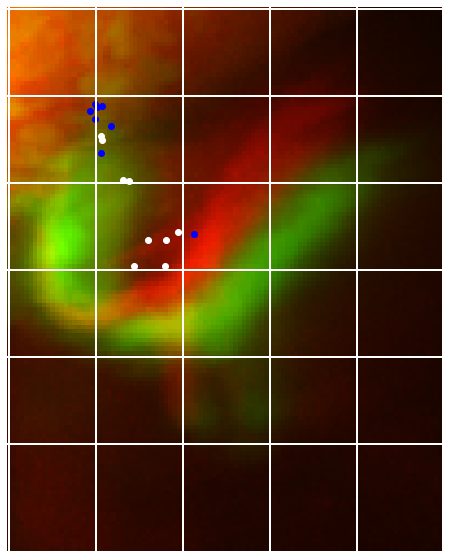

In [42]:
plt.figure(figsize=(10,10))
axis = 1
uncropped = True


type1 = 'clandinin'
type2 = 'murthy'

if uncropped:
    g=np.max(meanbrains[type1],axis=axis)
    r=np.max(meanbrains[type2],axis=axis)
    #b=np.max(LC11_fda_cropped*pvlp_mask_cropped, axis=axis)
else:
    g=np.max(mean_binary_image_c,axis=axis)
    r=np.max(mean_binary_image_m,axis=axis)
    #b=np.max(LC11_fda_cropped*pvlp_mask_cropped, axis=axis)

b = np.zeros(g.shape)
    
g/=np.max(g)
r/=np.max(r)
b/=np.max(b)
rgb = np.concatenate((r[...,np.newaxis],g[...,np.newaxis],b[...,np.newaxis]),axis=2)
plt.imshow(rgb)

for i in range(len(centroids[type1])):
    plot_centroid(centroids[type1][i][0],
                  centroids[type1][i][1],
                  centroids[type1][i][2],axis,color='w')
    
for i in range(len(centroids[type2])):
    plot_centroid(centroids[type2][i][0],
                  centroids[type2][i][1],
                  centroids[type2][i][2],axis,color='blue')
    
# for i in range(len(centroids['connectome'])):
#     plot_centroid(centroids['connectome'][i][0],
#                   centroids['connectome'][i][1],
#                   centroids['connectome'][i][2],axis,color='r')

draw_grid(vlines=5, hlines=6, lw=2)
plt.axis('off')

In [49]:
comparisons = [('clandinin', 'clandinin'), #intra
               ('murthy', 'murthy'),#intra
               ('clandinin_flip', 'clandinin_flip'),#intra
               ('murthy_flip', 'murthy_flip'),#intra
               ('clandinin', 'clandinin_flip'),#cross-hemi
               ('murthy', 'murthy_flip'),#cross-hemi
               ('clandinin', 'murthy'),#cross-lab
               ('clandinin', 'murthy_flip'),#cross-lab
               ('clandinin_flip', 'murthy'),#cross-lab
               ('clandinin_flip', 'murthy_flip'),#cross-lab
               ('clandinin', 'connectome'),#connectome
               ('clandinin_flip', 'connectome'),#connectome
               ('murthy', 'connectome'),#connectome
               ('murthy_flip', 'connectome')]#connectome

comparison_means = {}
comparison_std = {}
for comparison in comparisons:
    brain_type_1 = comparison[0]
    brain_type_2 = comparison[1]
    
    pairwise_diffs = []
    for axis in [0,1,2]:
        a=[i[axis] for i in centroids[brain_type_1]]
        b=[i[axis] for i in centroids[brain_type_2]]
        
        ### if it is an intra comparison, skip comparisons of exact same brains
        if brain_type_1 == brain_type_2:
            pairwise_diff = [np.abs((x-y)*.76) for i,x in enumerate(a) for j,y in enumerate(a) if i != j]
        else:
            pairwise_diff = [np.abs((x-y)*.76) for x in a for y in b]
        pairwise_diffs.append(pairwise_diff)
    
    ### calculate distances given all 3 axes
    distances = (np.asarray(pairwise_diffs[0])**2 +
             np.asarray(pairwise_diffs[1])**2 + 
             np.asarray(pairwise_diffs[2])**2)**0.5
    
    comparison_means[comparison] = np.mean(distances)
    comparison_std[comparison] = np.std(distances)

(0, 18)

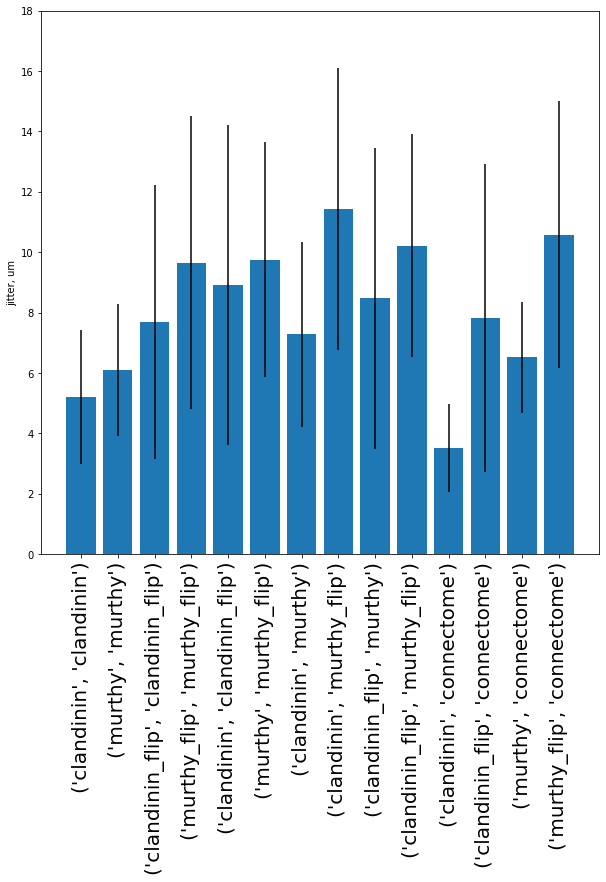

In [50]:
plt.figure(figsize=(10,10))
xs = list(range(len(comparisons)))
plt.bar([str(i) for i in comparisons], list(comparison_means.values()), yerr=list(comparison_std.values()))
plt.xticks(rotation=90,fontsize=20)
plt.ylabel("jitter, um")
plt.ylim(0,18)

In [82]:
file = '/oak/stanford/groups/trc/data/berger/registration/meanbrain_building/'
os.listdir(file)

['serial_regression_test',
 'ants_test',
 'old',
 'sama_local_meanbrain',
 'sama_local_meanbrain_mirror',
 'sama_mc_meanbrain',
 'progressive_clahe_good',
 'sama_mc_meanbrain_mirror',
 'progressive_clahe_full',
 'transform_clahe_full',
 'sharpen_test',
 'transform_02_clahe_good']

In [84]:
file = '/oak/stanford/groups/trc/data/berger/registration/meanbrain_building/sama_local_meanbrain_mirror/preprocessed'
os.listdir(file)

['220127_local_atlas.nii',
 '220125_local_atlas.nii',
 '220515_2_local_atlas.nii',
 '220210_local_atlas.nii',
 '211207_local_atlas.nii',
 '220515_3_local_atlas.nii',
 '220517_1_local_atlas.nii']

In [ ]:
['220127_local_atlas.nii',
 '220125_local_atlas.nii',
 '220515_2_local_atlas.nii',
 '220210_local_atlas.nii',
 '211207_local_atlas.nii',
 '220515_3_local_atlas.nii',
 '220517_1_local_atlas.nii']

In [116]:
dir_ = "/oak/stanford/groups/trc/data/berger/registration/meanbrain_building/sama_local_meanbrain_mirror/preprocessed/"
sama_brains = []
files = os.listdir(dir_)
for file in files:
    print(file)
    fullfile = os.path.join(dir_,file)
    temp = ants.image_read(fullfile)[:]
    sama_brains.append(temp)

220127_local_atlas.nii
220125_local_atlas.nii
220515_2_local_atlas.nii
220210_local_atlas.nii
211207_local_atlas.nii
220515_3_local_atlas.nii
220517_1_local_atlas.nii


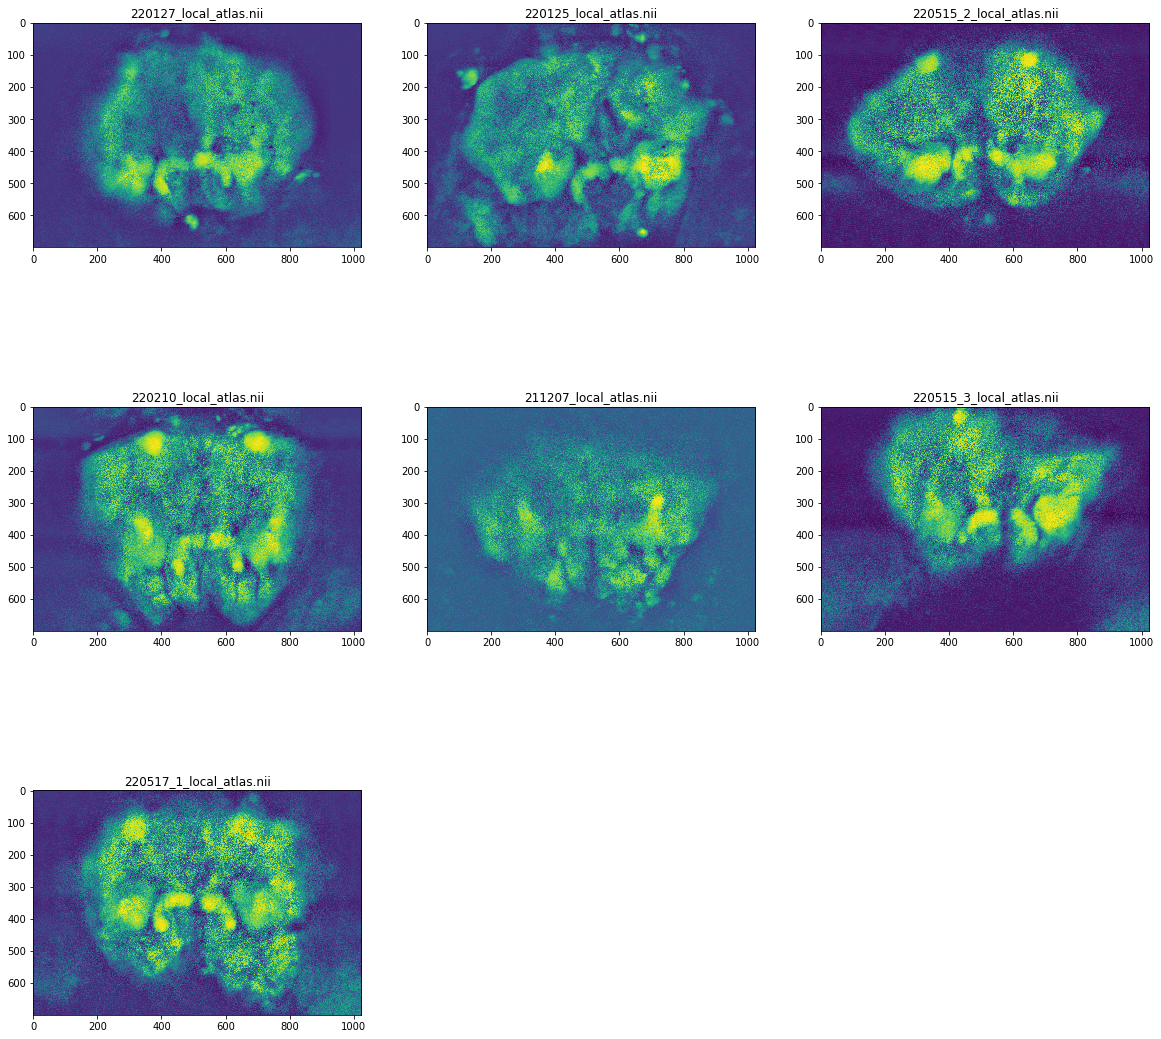

In [124]:
plt.figure(figsize=(20,20))
for i in range(len(sama_brains)):
    plt.subplot(3,3,i+1)
    #plt.imshow(np.max(sama_brains[i],axis=2).T)
    plt.imshow(sama_brains[i][:,:,90].T)
    plt.title(files[i])

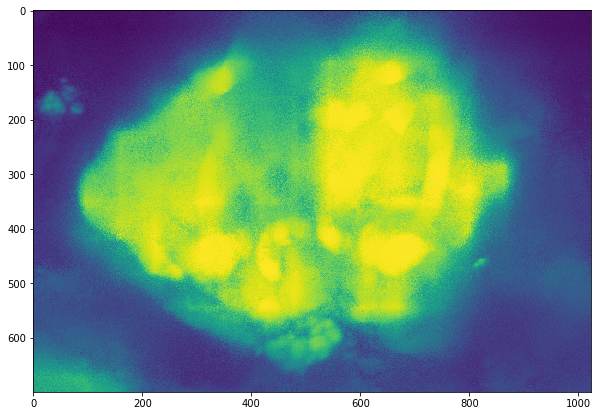

In [111]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(temp,axis=2).T)

In [57]:
temp.shape

(1024, 700, 249)

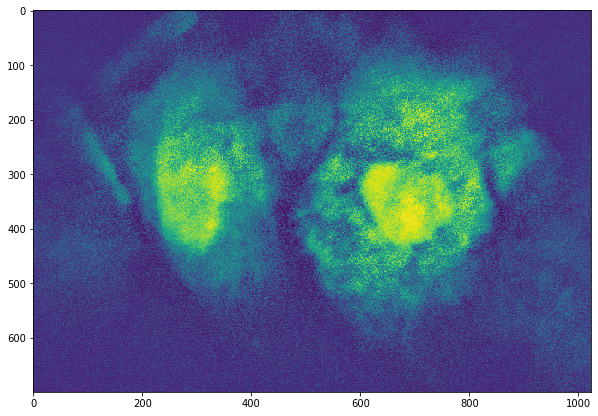

In [123]:
plt.figure(figsize=(10,10))
plt.imshow(temp[:,:,50].T)